In [16]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable

In [17]:
def f(x,y):
    return x % 1.0

In [18]:
def visualise(f, minx=0.0, maxx=1.0, miny=0.0, maxy=1.0, width=256, height=256):
    xwidth = maxx - minx
    yheight = maxy - miny
    
    def get_pixel(row, column):
        x = column / (width-1) * xwidth + minx
        y = row / (height-1) * yheight + miny
        return f(x,y)

    pixels = np.fromfunction(get_pixel, (height, width))
    pixels = np.flipud(pixels).astype(float)*255
    return Image.fromarray(pixels).convert('L')

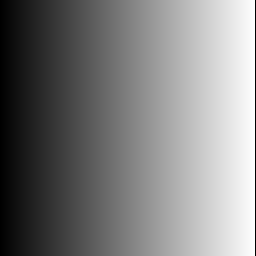

In [19]:
visualise(f)

In [20]:
def f(x,y):
    return x + y

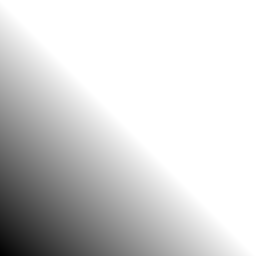

In [21]:
visualise(f)

In [22]:
columns = 256
rows = 256

x = np.arange(0,columns,1)
y = np.arange(0,rows,1)

X, Y = np.meshgrid(x, y)

SEED = [1,2,3,4]
random = np.random.RandomState(SEED)

random_angles = random.rand(rows,columns) * (2 * np.pi)

x_components = np.cos(random_angles)
y_components = np.sin(random_angles)

In [23]:
# This is perhaps not needed? Repetition of below.
# fig, ax = plt.subplots()

# x_pos = X
# y_pos = Y
# x_direct = x_components
# y_direct = y_components

# ax.quiver(x_pos,y_pos,x_direct,y_direct, angles='xy', scale_units='xy', scale=2)

# plt.show()

In [24]:
class RandomGradientGrid:
    def __init__(self, seed, width, height):
        x = np.arange(0,width,1)
        y = np.arange(0,height,1)

        X, Y = np.meshgrid(x, y)

        random = np.random.RandomState(seed)

        random_angles = random.rand(rows,columns) * (2 * np.pi)

        self.x_components = np.cos(random_angles)
        self.y_components = np.sin(random_angles)
        self.width = width
        self.height = height
    def get_gradient_at(self, x, y):
        gx = self.x_components[y % self.height, x % self.width]
        gy = self.y_components[y % self.height, x % self.width]
        return gx, gy

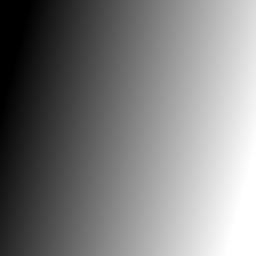

In [25]:
gradient_grid_1 = RandomGradientGrid(1234, 256, 256)

def colour_point_by_gradient(x, y, gradient_column, gradient_row):
    gx, gy = gradient_grid_1.get_gradient_at(gradient_column, gradient_row)
    dot_product = (x * gx) + (y * gy)

    return dot_product * 0.5 + 0.5


def f(x,y):
    return colour_point_by_gradient(x, y, 3, 5)

visualise(f, minx=-1.0, maxx=1.0, miny=-1.0, maxy=1.0)

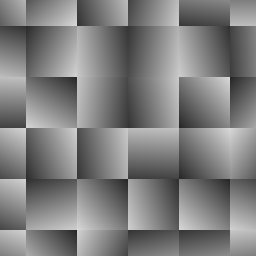

In [26]:
COLOUR_FUNC = Callable[[float, float], float]
GRID_FUNC = Callable[[int, int], COLOUR_FUNC]

def interpolate_nearest_neighbour(get_colour_func_for_grid_cell: GRID_FUNC) -> COLOUR_FUNC:
    def get_pixel_colour(x: float,y: float) -> float:
        grid_x = np.round(x).astype(int)
        grid_y = np.round(y).astype(int)

        pixel_func = get_colour_func_for_grid_cell(grid_x,grid_y)
        return pixel_func(x,y)
    
    return get_pixel_colour

def get_gradient_colour_func_for_grid_cell(grid_x: int, grid_y: int) -> COLOUR_FUNC:
    def get_pixel_colour(x,y):
        return colour_point_by_gradient(x - grid_x, y - grid_y, grid_x, grid_y)

    return get_pixel_colour

visualise(interpolate_nearest_neighbour(get_gradient_colour_func_for_grid_cell), minx=0, maxx=5.0, miny=0, maxy=5.0)

We've made a sort of quilted pattern by just stitching the gradients together. But what we really want to do is _blend_ them smoothly, one into another. Let's first of all define some smoothing functions.

In [27]:
def lerp(start, end, t):
    return start * (1 - t) + t * end
def smoothstep(start, end, t):
    return start + t * t * (3.0 - 2.0 * t) * (end - start)
def nearest_neighbour(start, end, t):
    if t>=0.5:
        return end
    return start

Now we can smoothly interpolate between the gradients defined by the four neighbouring grid points to the pixel we're trying to colour in.

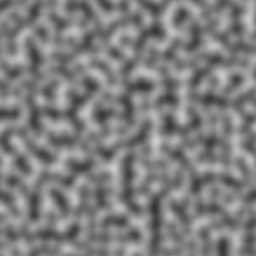

In [28]:
def interpolate_linearly(get_colour_func_for_grid_cell: GRID_FUNC) -> COLOUR_FUNC:
    def get_pixel_colour(x: float,y: float) -> float:
        left_grid_x = np.floor(x).astype(int)
        right_grid_x = left_grid_x + 1
        lower_grid_y = np.floor(y).astype(int)
        upper_grid_y = lower_grid_y + 1

        x_remainder = x - left_grid_x
        y_remainder = y - lower_grid_y

        lower_left_pixel = get_colour_func_for_grid_cell(left_grid_x, lower_grid_y)(x,y)
        lower_right_pixel = get_colour_func_for_grid_cell(right_grid_x, lower_grid_y)(x,y)
        upper_left_pixel = get_colour_func_for_grid_cell(left_grid_x, upper_grid_y)(x,y)
        upper_right_pixel = get_colour_func_for_grid_cell(right_grid_x, upper_grid_y)(x,y)

        
        lower_lerp_pixel = smoothstep(lower_left_pixel, lower_right_pixel, x_remainder)
        upper_lerp_pixel = smoothstep(upper_left_pixel, upper_right_pixel, x_remainder)
        final_pixel = smoothstep(lower_lerp_pixel, upper_lerp_pixel, y_remainder)
        
        return final_pixel
    
    return get_pixel_colour

visualise(interpolate_linearly(get_gradient_colour_func_for_grid_cell), minx=0, maxx=18.9, miny=0, maxy=18.9)

Okay, we've demonstrated simple 2D Perlin noise. But we would like to be able to combine it at multiple scales in order to make fluffy cloud effects, fractal mountains, etc. Lets write some functions to combine our functions.

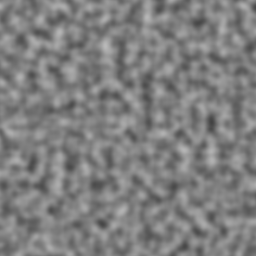

In [29]:
def add_colour_funcs(*fs):
    def get_added_value(x,y):
        return sum(f(x,y) for f in fs)
    return get_added_value

def scale_colour_func(sx, sy, f):
    def get_scaled_value(x, y):
        return f(x / sx, y / sy)
    return get_scaled_value

def adjust_brightness_of_colour_func(brightening, f):
    def get_brightened_value(x, y):
        return brightening + f(x, y)
    return get_brightened_value

def adjust_contrast_of_colour_func(contrast_multiplier, f):
    def get_adjusted_value(x, y):
        return contrast_multiplier * f(x, y)
    return get_adjusted_value

perlin_1 = interpolate_linearly(get_gradient_colour_func_for_grid_cell)
perlin_2 = scale_colour_func(0.707, 0.707, perlin_1)
perlin_3 = scale_colour_func(0.5, 0.5, perlin_1)
mixed_perlin = add_colour_funcs(
    adjust_contrast_of_colour_func(0.6, perlin_1),
    adjust_contrast_of_colour_func(0.3, perlin_2),
    adjust_contrast_of_colour_func(0.1, perlin_3),
    )
visualise(mixed_perlin, minx=0, maxx=20, miny=-10, maxy=10)

It's awkward to keep manipulating colour_funcs like we have been. It would be nice to treat them like we do numpy arrays and, for example, add them together with the + operator, multiply them with the * operator and so on. Let's try that... (Probably don't include this in the blog post. It might be more useful in a follow-up if we want to experiment with _using_ perlin noise as a component in creating interesting textures and effects.)

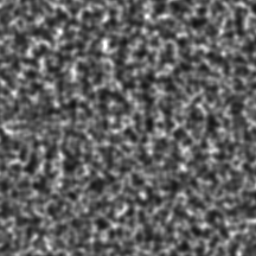

In [30]:
class ModifiableColourFunc:
    def __init__(self, f):
        self.f = f
    def __call__(self, x, y):
        return self.f(x, y)
    def __add__(self, other):
        if isinstance(other, ModifiableColourFunc):
            def combined_f(x, y):
                return self.f(x, y) + other.f(x, y)
            return ModifiableColourFunc(combined_f)
        def combined_f(x, y):
            return self.f(x, y) + other
        return ModifiableColourFunc(combined_f)
    def __mul__(self, other):
        if isinstance(other, ModifiableColourFunc):
            def combined_f(x, y):
                return self.f(x, y) * other.f(x, y)
            return ModifiableColourFunc(combined_f)
        def combined_f(x, y):
            return self.f(x, y) * other
        return ModifiableColourFunc(combined_f)
    def scale(self, sx, sy):
        return ModifiableColourFunc(scale_colour_func(sx, sy, self.f))

perlin_1 = ModifiableColourFunc(interpolate_linearly(get_gradient_colour_func_for_grid_cell))
perlin_2 = perlin_1.scale(0.707, 0.707)
perlin_3 = perlin_1.scale(0.5, 0.5)
mixed_perlin = (
    perlin_1 *
    perlin_2 * 
    perlin_3 * 3.0
)
visualise(mixed_perlin, minx=0, maxx=20, miny=-10, maxy=10)
                
